In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, learning_curve, validation_curve

In [3]:
df = pd.read_csv("~/projects/us-education-datasets-unification-project/data/us-education-datasets-unification-project/states_all.csv")

In [4]:
df.shape

(1492, 25)

In [5]:
np.sqrt(df.shape[0])
df.shape[0]/50

29.84

In [6]:
df.head(5)

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,GRADES_4_G,GRADES_8_G,GRADES_12_G,GRADES_1_8_G,GRADES_9_12_G,GRADES_ALL_G,AVG_MATH_4_SCORE,AVG_MATH_8_SCORE,AVG_READING_4_SCORE,AVG_READING_8_SCORE
0,1992_ALABAMA,ALABAMA,1992,NaN,2678885.0,304177.0,1659028.0,715680.0,2653798.0,1481703.0,...,57948.0,58025.0,41167.0,471564.0,196386.0,676174.0,208.327876,252.187522,207.963517,NaN
1,1992_ALASKA,ALASKA,1992,NaN,1049591.0,106780.0,720711.0,222100.0,972488.0,498362.0,...,9748.0,8789.0,6714.0,79117.0,30847.0,112335.0,NaN,NaN,NaN,258.859712
2,1992_ARIZONA,ARIZONA,1992,NaN,3258079.0,297888.0,1369815.0,1590376.0,3401580.0,1435908.0,...,55433.0,49081.0,37410.0,437127.0,175210.0,614881.0,215.253932,265.366278,206.212716,262.169895
3,1992_ARKANSAS,ARKANSAS,1992,NaN,1711959.0,178571.0,958785.0,574603.0,1743022.0,964323.0,...,34632.0,36011.0,27651.0,281338.0,123113.0,405259.0,210.206028,256.312090,208.634458,264.619665
4,1992_CALIFORNIA,CALIFORNIA,1992,NaN,26260025.0,2072470.0,16546514.0,7641041.0,27138832.0,14358922.0,...,418418.0,363296.0,270675.0,3286034.0,1372011.0,4717112.0,208.398961,260.892247,196.764414,NaN


In [7]:
df.columns.tolist()

['PRIMARY_KEY',
 'STATE',
 'YEAR',
 'ENROLL',
 'TOTAL_REVENUE',
 'FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE',
 'TOTAL_EXPENDITURE',
 'INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE',
 'GRADES_PK_G',
 'GRADES_KG_G',
 'GRADES_4_G',
 'GRADES_8_G',
 'GRADES_12_G',
 'GRADES_1_8_G',
 'GRADES_9_12_G',
 'GRADES_ALL_G',
 'AVG_MATH_4_SCORE',
 'AVG_MATH_8_SCORE',
 'AVG_READING_4_SCORE',
 'AVG_READING_8_SCORE']

In [8]:
set(df[df['AVG_MATH_4_SCORE']>0]['YEAR'].subtract(1).tolist())

{1991, 1995, 1999, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016}

In [48]:
df['avg_total_revenue']=df['TOTAL_REVENUE']/df['GRADES_ALL_G']
df['avg_total_expenditure'] = df['TOTAL_EXPENDITURE'] / df['GRADES_ALL_G']

df['fracn_schoolage'] = df['GRADES_ALL_G']/df['ENROLL']
df['rev_per_person'] = df['TOTAL_REVENUE'] / df['ENROLL']
df['exp_per_rev'] = df['TOTAL_EXPENDITURE'] / df['TOTAL_REVENUE']

#Models want to know about drop-out rate
#Subtract take ratio GRADES_12_G(YEAR)/GRADES_8_G(YEAR-4)
for state in set(df['STATE'].tolist()):
    for year in set(df['YEAR'].tolist()):
        key= "{}_{}".format(year, state)
        lag_year = year-4
        lag_key= "{}_{}".format(lag_year, state)
        if np.any(df['PRIMARY_KEY']==lag_key):
            df.loc[df['PRIMARY_KEY']==key, 'fracn_GRADES_12div8_G']= np.divide( \
                df[df['PRIMARY_KEY']==key]['GRADES_12_G'], np.median(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G']))
            
        #Most recent AVG_MATH_4_SCORE for STATE
        for lag_year in np.arange(year-6,year-1):
            lag_key= "{}_{}".format(lag_year, state)
            if np.any(df['PRIMARY_KEY']== lag_key):
                if np.all(df[df['PRIMARY_KEY'] == lag_key]['AVG_MATH_4_SCORE'].notnull()):
                    df.loc[df['PRIMARY_KEY']==key, 'recent_AVG_MATH_4_SCORE']= \
                        df[df['PRIMARY_KEY'] == lag_key]['AVG_MATH_4_SCORE']
                    print(df[df['PRIMARY_KEY'] == lag_key]['AVG_MATH_4_SCORE'])

24    201.828261
Name: AVG_MATH_4_SCORE, dtype: float64
24    201.828261
Name: AVG_MATH_4_SCORE, dtype: float64
24    201.828261
Name: AVG_MATH_4_SCORE, dtype: float64
24    201.828261
Name: AVG_MATH_4_SCORE, dtype: float64
24    201.828261
Name: AVG_MATH_4_SCORE, dtype: float64
228    208.434119
Name: AVG_MATH_4_SCORE, dtype: float64
228    208.434119
Name: AVG_MATH_4_SCORE, dtype: float64
228    208.434119
Name: AVG_MATH_4_SCORE, dtype: float64
228    208.434119
Name: AVG_MATH_4_SCORE, dtype: float64
228    208.434119
Name: AVG_MATH_4_SCORE, dtype: float64
432    210.97035
Name: AVG_MATH_4_SCORE, dtype: float64
432    210.97035
Name: AVG_MATH_4_SCORE, dtype: float64
432    210.97035
Name: AVG_MATH_4_SCORE, dtype: float64
432    210.97035
Name: AVG_MATH_4_SCORE, dtype: float64
585    222.890601
Name: AVG_MATH_4_SCORE, dtype: float64
432    210.97035
Name: AVG_MATH_4_SCORE, dtype: float64
585    222.890601
Name: AVG_MATH_4_SCORE, dtype: float64
585    222.890601
Name: AVG_MATH_4_SCORE,

5    221.023429
Name: AVG_MATH_4_SCORE, dtype: float64
5    221.023429
Name: AVG_MATH_4_SCORE, dtype: float64
5    221.023429
Name: AVG_MATH_4_SCORE, dtype: float64
5    221.023429
Name: AVG_MATH_4_SCORE, dtype: float64
5    221.023429
Name: AVG_MATH_4_SCORE, dtype: float64
209    225.805858
Name: AVG_MATH_4_SCORE, dtype: float64
209    225.805858
Name: AVG_MATH_4_SCORE, dtype: float64
209    225.805858
Name: AVG_MATH_4_SCORE, dtype: float64
209    225.805858
Name: AVG_MATH_4_SCORE, dtype: float64
209    225.805858
Name: AVG_MATH_4_SCORE, dtype: float64
566    235.193116
Name: AVG_MATH_4_SCORE, dtype: float64
566    235.193116
Name: AVG_MATH_4_SCORE, dtype: float64
566    235.193116
Name: AVG_MATH_4_SCORE, dtype: float64
668    239.215874
Name: AVG_MATH_4_SCORE, dtype: float64
566    235.193116
Name: AVG_MATH_4_SCORE, dtype: float64
668    239.215874
Name: AVG_MATH_4_SCORE, dtype: float64
566    235.193116
Name: AVG_MATH_4_SCORE, dtype: float64
668    239.215874
Name: AVG_MATH_4_SCORE,

11    214.056666
Name: AVG_MATH_4_SCORE, dtype: float64
11    214.056666
Name: AVG_MATH_4_SCORE, dtype: float64
11    214.056666
Name: AVG_MATH_4_SCORE, dtype: float64
11    214.056666
Name: AVG_MATH_4_SCORE, dtype: float64
11    214.056666
Name: AVG_MATH_4_SCORE, dtype: float64
215    214.965562
Name: AVG_MATH_4_SCORE, dtype: float64
215    214.965562
Name: AVG_MATH_4_SCORE, dtype: float64
215    214.965562
Name: AVG_MATH_4_SCORE, dtype: float64
215    214.965562
Name: AVG_MATH_4_SCORE, dtype: float64
215    214.965562
Name: AVG_MATH_4_SCORE, dtype: float64
419    215.846799
Name: AVG_MATH_4_SCORE, dtype: float64
419    215.846799
Name: AVG_MATH_4_SCORE, dtype: float64
419    215.846799
Name: AVG_MATH_4_SCORE, dtype: float64
419    215.846799
Name: AVG_MATH_4_SCORE, dtype: float64
572    226.83461
Name: AVG_MATH_4_SCORE, dtype: float64
419    215.846799
Name: AVG_MATH_4_SCORE, dtype: float64
572    226.83461
Name: AVG_MATH_4_SCORE, dtype: float64
572    226.83461
Name: AVG_MATH_4_SCOR

905    245.189526
Name: AVG_MATH_4_SCORE, dtype: float64
1008    245.156416
Name: AVG_MATH_4_SCORE, dtype: float64
905    245.189526
Name: AVG_MATH_4_SCORE, dtype: float64
1008    245.156416
Name: AVG_MATH_4_SCORE, dtype: float64
1110    246.424795
Name: AVG_MATH_4_SCORE, dtype: float64
1008    245.156416
Name: AVG_MATH_4_SCORE, dtype: float64
1110    246.424795
Name: AVG_MATH_4_SCORE, dtype: float64
1008    245.156416
Name: AVG_MATH_4_SCORE, dtype: float64
1110    246.424795
Name: AVG_MATH_4_SCORE, dtype: float64
1212    244.713831
Name: AVG_MATH_4_SCORE, dtype: float64
6    226.79848
Name: AVG_MATH_4_SCORE, dtype: float64
6    226.79848
Name: AVG_MATH_4_SCORE, dtype: float64
6    226.79848
Name: AVG_MATH_4_SCORE, dtype: float64
6    226.79848
Name: AVG_MATH_4_SCORE, dtype: float64
6    226.79848
Name: AVG_MATH_4_SCORE, dtype: float64
210    232.026574
Name: AVG_MATH_4_SCORE, dtype: float64
210    232.026574
Name: AVG_MATH_4_SCORE, dtype: float64
210    232.026574
Name: AVG_MATH_4_SCO

235    213.844025
Name: AVG_MATH_4_SCORE, dtype: float64
439    213.868301
Name: AVG_MATH_4_SCORE, dtype: float64
439    213.868301
Name: AVG_MATH_4_SCORE, dtype: float64
439    213.868301
Name: AVG_MATH_4_SCORE, dtype: float64
439    213.868301
Name: AVG_MATH_4_SCORE, dtype: float64
592    222.518009
Name: AVG_MATH_4_SCORE, dtype: float64
439    213.868301
Name: AVG_MATH_4_SCORE, dtype: float64
592    222.518009
Name: AVG_MATH_4_SCORE, dtype: float64
592    222.518009
Name: AVG_MATH_4_SCORE, dtype: float64
694    224.027218
Name: AVG_MATH_4_SCORE, dtype: float64
592    222.518009
Name: AVG_MATH_4_SCORE, dtype: float64
694    224.027218
Name: AVG_MATH_4_SCORE, dtype: float64
592    222.518009
Name: AVG_MATH_4_SCORE, dtype: float64
694    224.027218
Name: AVG_MATH_4_SCORE, dtype: float64
796    228.064313
Name: AVG_MATH_4_SCORE, dtype: float64
694    224.027218
Name: AVG_MATH_4_SCORE, dtype: float64
796    228.064313
Name: AVG_MATH_4_SCORE, dtype: float64
694    224.027218
Name: AVG_MAT

893    236.27972
Name: AVG_MATH_4_SCORE, dtype: float64
996    236.402214
Name: AVG_MATH_4_SCORE, dtype: float64
893    236.27972
Name: AVG_MATH_4_SCORE, dtype: float64
996    236.402214
Name: AVG_MATH_4_SCORE, dtype: float64
893    236.27972
Name: AVG_MATH_4_SCORE, dtype: float64
996    236.402214
Name: AVG_MATH_4_SCORE, dtype: float64
1098    236.819778
Name: AVG_MATH_4_SCORE, dtype: float64
996    236.402214
Name: AVG_MATH_4_SCORE, dtype: float64
1098    236.819778
Name: AVG_MATH_4_SCORE, dtype: float64
996    236.402214
Name: AVG_MATH_4_SCORE, dtype: float64
1098    236.819778
Name: AVG_MATH_4_SCORE, dtype: float64
1200    235.728894
Name: AVG_MATH_4_SCORE, dtype: float64
3    210.206028
Name: AVG_MATH_4_SCORE, dtype: float64
3    210.206028
Name: AVG_MATH_4_SCORE, dtype: float64
3    210.206028
Name: AVG_MATH_4_SCORE, dtype: float64
3    210.206028
Name: AVG_MATH_4_SCORE, dtype: float64
3    210.206028
Name: AVG_MATH_4_SCORE, dtype: float64
207    215.846436
Name: AVG_MATH_4_SCORE

423    232.896935
Name: AVG_MATH_4_SCORE, dtype: float64
576    238.476695
Name: AVG_MATH_4_SCORE, dtype: float64
423    232.896935
Name: AVG_MATH_4_SCORE, dtype: float64
576    238.476695
Name: AVG_MATH_4_SCORE, dtype: float64
576    238.476695
Name: AVG_MATH_4_SCORE, dtype: float64
678    239.880802
Name: AVG_MATH_4_SCORE, dtype: float64
576    238.476695
Name: AVG_MATH_4_SCORE, dtype: float64
678    239.880802
Name: AVG_MATH_4_SCORE, dtype: float64
576    238.476695
Name: AVG_MATH_4_SCORE, dtype: float64
678    239.880802
Name: AVG_MATH_4_SCORE, dtype: float64
780    242.819589
Name: AVG_MATH_4_SCORE, dtype: float64
678    239.880802
Name: AVG_MATH_4_SCORE, dtype: float64
780    242.819589
Name: AVG_MATH_4_SCORE, dtype: float64
678    239.880802
Name: AVG_MATH_4_SCORE, dtype: float64
780    242.819589
Name: AVG_MATH_4_SCORE, dtype: float64
886    242.595644
Name: AVG_MATH_4_SCORE, dtype: float64
780    242.819589
Name: AVG_MATH_4_SCORE, dtype: float64
886    242.595644
Name: AVG_MAT

36    220.319806
Name: AVG_MATH_4_SCORE, dtype: float64
36    220.319806
Name: AVG_MATH_4_SCORE, dtype: float64
444    225.041922
Name: AVG_MATH_4_SCORE, dtype: float64
444    225.041922
Name: AVG_MATH_4_SCORE, dtype: float64
444    225.041922
Name: AVG_MATH_4_SCORE, dtype: float64
444    225.041922
Name: AVG_MATH_4_SCORE, dtype: float64
597    229.096621
Name: AVG_MATH_4_SCORE, dtype: float64
444    225.041922
Name: AVG_MATH_4_SCORE, dtype: float64
597    229.096621
Name: AVG_MATH_4_SCORE, dtype: float64
597    229.096621
Name: AVG_MATH_4_SCORE, dtype: float64
699    233.955329
Name: AVG_MATH_4_SCORE, dtype: float64
597    229.096621
Name: AVG_MATH_4_SCORE, dtype: float64
699    233.955329
Name: AVG_MATH_4_SCORE, dtype: float64
597    229.096621
Name: AVG_MATH_4_SCORE, dtype: float64
699    233.955329
Name: AVG_MATH_4_SCORE, dtype: float64
801    236.802194
Name: AVG_MATH_4_SCORE, dtype: float64
699    233.955329
Name: AVG_MATH_4_SCORE, dtype: float64
801    236.802194
Name: AVG_MATH_

878    219.260141
879    219.260141
Name: AVG_MATH_4_SCORE, dtype: float64
982    221.808283
Name: AVG_MATH_4_SCORE, dtype: float64
878    219.260141
879    219.260141
Name: AVG_MATH_4_SCORE, dtype: float64
982    221.808283
Name: AVG_MATH_4_SCORE, dtype: float64
878    219.260141
879    219.260141
Name: AVG_MATH_4_SCORE, dtype: float64
982    221.808283
Name: AVG_MATH_4_SCORE, dtype: float64
1084    228.567254
Name: AVG_MATH_4_SCORE, dtype: float64
982    221.808283
Name: AVG_MATH_4_SCORE, dtype: float64
1084    228.567254
Name: AVG_MATH_4_SCORE, dtype: float64
982    221.808283
Name: AVG_MATH_4_SCORE, dtype: float64
1084    228.567254
Name: AVG_MATH_4_SCORE, dtype: float64
1186    231.307525
Name: AVG_MATH_4_SCORE, dtype: float64
12    221.562534
Name: AVG_MATH_4_SCORE, dtype: float64
12    221.562534
Name: AVG_MATH_4_SCORE, dtype: float64
12    221.562534
Name: AVG_MATH_4_SCORE, dtype: float64
12    221.562534
Name: AVG_MATH_4_SCORE, dtype: float64
12    221.562534
Name: AVG_MATH_4_

441    232.463065
Name: AVG_MATH_4_SCORE, dtype: float64
441    232.463065
Name: AVG_MATH_4_SCORE, dtype: float64
441    232.463065
Name: AVG_MATH_4_SCORE, dtype: float64
441    232.463065
Name: AVG_MATH_4_SCORE, dtype: float64
594    242.040126
Name: AVG_MATH_4_SCORE, dtype: float64
441    232.463065
Name: AVG_MATH_4_SCORE, dtype: float64
594    242.040126
Name: AVG_MATH_4_SCORE, dtype: float64
594    242.040126
Name: AVG_MATH_4_SCORE, dtype: float64
696    241.235549
Name: AVG_MATH_4_SCORE, dtype: float64
594    242.040126
Name: AVG_MATH_4_SCORE, dtype: float64
696    241.235549
Name: AVG_MATH_4_SCORE, dtype: float64
594    242.040126
Name: AVG_MATH_4_SCORE, dtype: float64
696    241.235549
Name: AVG_MATH_4_SCORE, dtype: float64
798    241.617994
Name: AVG_MATH_4_SCORE, dtype: float64
696    241.235549
Name: AVG_MATH_4_SCORE, dtype: float64
798    241.617994
Name: AVG_MATH_4_SCORE, dtype: float64
696    241.235549
Name: AVG_MATH_4_SCORE, dtype: float64
798    241.617994
Name: AVG_MAT

32    218.445535
Name: AVG_MATH_4_SCORE, dtype: float64
236    222.634059
Name: AVG_MATH_4_SCORE, dtype: float64
236    222.634059
Name: AVG_MATH_4_SCORE, dtype: float64
236    222.634059
Name: AVG_MATH_4_SCORE, dtype: float64
236    222.634059
Name: AVG_MATH_4_SCORE, dtype: float64
236    222.634059
Name: AVG_MATH_4_SCORE, dtype: float64
440    226.559061
Name: AVG_MATH_4_SCORE, dtype: float64
440    226.559061
Name: AVG_MATH_4_SCORE, dtype: float64
440    226.559061
Name: AVG_MATH_4_SCORE, dtype: float64
440    226.559061
Name: AVG_MATH_4_SCORE, dtype: float64
593    235.930075
Name: AVG_MATH_4_SCORE, dtype: float64
440    226.559061
Name: AVG_MATH_4_SCORE, dtype: float64
593    235.930075
Name: AVG_MATH_4_SCORE, dtype: float64
593    235.930075
Name: AVG_MATH_4_SCORE, dtype: float64
695    238.173977
Name: AVG_MATH_4_SCORE, dtype: float64
593    235.930075
Name: AVG_MATH_4_SCORE, dtype: float64
695    238.173977
Name: AVG_MATH_4_SCORE, dtype: float64
593    235.930075
Name: AVG_MATH

892    252.25479
Name: AVG_MATH_4_SCORE, dtype: float64
995    253.396456
Name: AVG_MATH_4_SCORE, dtype: float64
892    252.25479
Name: AVG_MATH_4_SCORE, dtype: float64
995    253.396456
Name: AVG_MATH_4_SCORE, dtype: float64
892    252.25479
Name: AVG_MATH_4_SCORE, dtype: float64
995    253.396456
Name: AVG_MATH_4_SCORE, dtype: float64
1097    253.033785
Name: AVG_MATH_4_SCORE, dtype: float64
995    253.396456
Name: AVG_MATH_4_SCORE, dtype: float64
1097    253.033785
Name: AVG_MATH_4_SCORE, dtype: float64
995    253.396456
Name: AVG_MATH_4_SCORE, dtype: float64
1097    253.033785
Name: AVG_MATH_4_SCORE, dtype: float64
1199    250.565778
Name: AVG_MATH_4_SCORE, dtype: float64
30    227.148047
Name: AVG_MATH_4_SCORE, dtype: float64
30    227.148047
Name: AVG_MATH_4_SCORE, dtype: float64
30    227.148047
Name: AVG_MATH_4_SCORE, dtype: float64
30    227.148047
Name: AVG_MATH_4_SCORE, dtype: float64
30    227.148047
Name: AVG_MATH_4_SCORE, dtype: float64
234    227.240167
Name: AVG_MATH_4_

227    232.193088
Name: AVG_MATH_4_SCORE, dtype: float64
227    232.193088
Name: AVG_MATH_4_SCORE, dtype: float64
227    232.193088
Name: AVG_MATH_4_SCORE, dtype: float64
227    232.193088
Name: AVG_MATH_4_SCORE, dtype: float64
431    235.270888
Name: AVG_MATH_4_SCORE, dtype: float64
431    235.270888
Name: AVG_MATH_4_SCORE, dtype: float64
431    235.270888
Name: AVG_MATH_4_SCORE, dtype: float64
431    235.270888
Name: AVG_MATH_4_SCORE, dtype: float64
584    241.912296
Name: AVG_MATH_4_SCORE, dtype: float64
431    235.270888
Name: AVG_MATH_4_SCORE, dtype: float64
584    241.912296
Name: AVG_MATH_4_SCORE, dtype: float64
584    241.912296
Name: AVG_MATH_4_SCORE, dtype: float64
686    245.746191
Name: AVG_MATH_4_SCORE, dtype: float64
584    241.912296
Name: AVG_MATH_4_SCORE, dtype: float64
686    245.746191
Name: AVG_MATH_4_SCORE, dtype: float64
584    241.912296
Name: AVG_MATH_4_SCORE, dtype: float64
686    245.746191
Name: AVG_MATH_4_SCORE, dtype: float64
788    246.997762
Name: AVG_MAT

1105    252.993525
Name: AVG_MATH_4_SCORE, dtype: float64
1207    249.150621
Name: AVG_MATH_4_SCORE, dtype: float64
25    222.2156
Name: AVG_MATH_4_SCORE, dtype: float64
25    222.2156
Name: AVG_MATH_4_SCORE, dtype: float64
25    222.2156
Name: AVG_MATH_4_SCORE, dtype: float64
25    222.2156
Name: AVG_MATH_4_SCORE, dtype: float64
25    222.2156
Name: AVG_MATH_4_SCORE, dtype: float64
229    224.734462
Name: AVG_MATH_4_SCORE, dtype: float64
229    224.734462
Name: AVG_MATH_4_SCORE, dtype: float64
229    224.734462
Name: AVG_MATH_4_SCORE, dtype: float64
229    224.734462
Name: AVG_MATH_4_SCORE, dtype: float64
229    224.734462
Name: AVG_MATH_4_SCORE, dtype: float64
433    228.552814
Name: AVG_MATH_4_SCORE, dtype: float64
433    228.552814
Name: AVG_MATH_4_SCORE, dtype: float64
433    228.552814
Name: AVG_MATH_4_SCORE, dtype: float64
433    228.552814
Name: AVG_MATH_4_SCORE, dtype: float64
586    234.836425
Name: AVG_MATH_4_SCORE, dtype: float64
433    228.552814
Name: AVG_MATH_4_SCORE, dt

In [49]:
print(np.count_nonzero(~np.isnan(df['recent_AVG_MATH_4_SCORE'])))
print(np.shape(df['recent_AVG_MATH_4_SCORE']))

print(df['recent_AVG_MATH_4_SCORE'])


0
(1492,)
0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
1462   NaN
1463   NaN
1464   NaN
1465   NaN
1466   NaN
1467   NaN
1468   NaN
1469   NaN
1470   NaN
1471   NaN
1472   NaN
1473   NaN
1474   NaN
1475   NaN
1476   NaN
1477   NaN
1478   NaN
1479   NaN
1480   NaN
1481   NaN
1482   NaN
1483   NaN
1484   NaN
1485   NaN
1486   NaN
1487   NaN
1488   NaN
1489   NaN
1490   NaN
1491   NaN
Name: recent_AVG_MATH_4_SCORE, Length: 1492, dtype: float64


In [10]:
print(key, lag_key)
print(df[df['PRIMARY_KEY']==key]['GRADES_12_G'])
print()
print(df[df['PRIMARY_KEY']==lag_key]['GRADES_8_G'])

2017_WYOMING 2015_WYOMING
1491   NaN
Name: GRADES_12_G, dtype: float64

1228    6902.0
Name: GRADES_8_G, dtype: float64


In [11]:
#Normalize expenditures to fraction of total expenditures
expenditure_cols = ['INSTRUCTION_EXPENDITURE',
 'SUPPORT_SERVICES_EXPENDITURE',
 'OTHER_EXPENDITURE',
 'CAPITAL_OUTLAY_EXPENDITURE']

for col in expenditure_cols:
    df['fracn_exp_{}'.format(col)] = df[col] / df['TOTAL_EXPENDITURE']
    #df=df.drop(col, axis=1)
    print('fracn_exp_{}'.format(col))

fracn_exp_INSTRUCTION_EXPENDITURE
fracn_exp_SUPPORT_SERVICES_EXPENDITURE
fracn_exp_OTHER_EXPENDITURE
fracn_exp_CAPITAL_OUTLAY_EXPENDITURE


In [12]:
#Normalize revenue to fraction of total revenue
revenue_cols = ['FEDERAL_REVENUE',
 'STATE_REVENUE',
 'LOCAL_REVENUE']

for col in revenue_cols:
    df['fracn_rev_{}'.format(col)] = df[col] / df['TOTAL_REVENUE']
    #df=df.drop(col, axis=1)
    print('fracn_rev_{}'.format(col))

fracn_rev_FEDERAL_REVENUE
fracn_rev_STATE_REVENUE
fracn_rev_LOCAL_REVENUE


In [13]:
#Normalize students enrolled to fraction of enrolled population
fracn_enroll_cols = ['GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G']

for col in fracn_enroll_cols:
    df['fracn_enroll_{}'.format(col)] = df[col] / df['GRADES_ALL_G']
    print('fracn_enroll_{}'.format(col))
    #df = df.drop(col, axis=1) 

fracn_enroll_GRADES_PK_G
fracn_enroll_GRADES_KG_G
fracn_enroll_GRADES_4_G
fracn_enroll_GRADES_8_G
fracn_enroll_GRADES_12_G
fracn_enroll_GRADES_1_8_G
fracn_enroll_GRADES_9_12_G


In [14]:
#sns.pairplot(df, kind='scatter')

(44, 44)


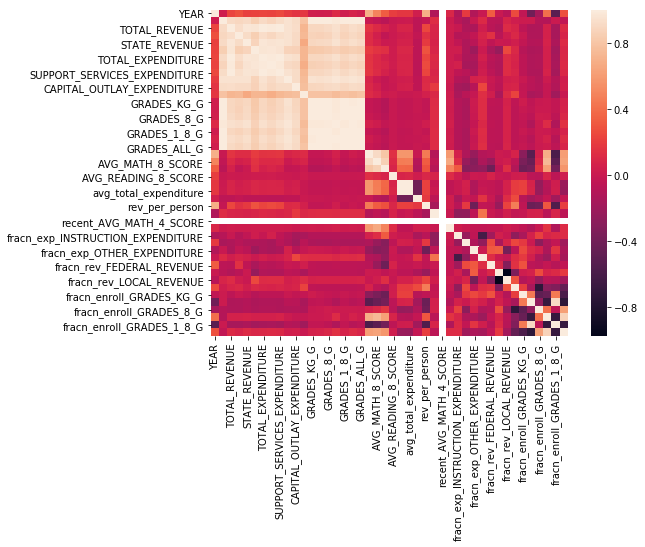

In [15]:
corr = df.corr()
print(corr.shape)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr)

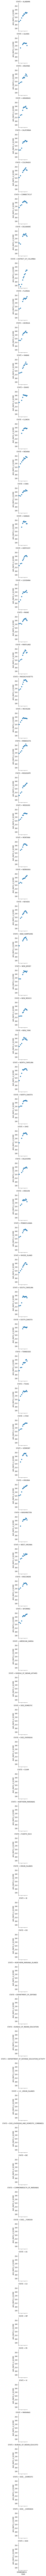

In [16]:
g = sns.FacetGrid(df, row="STATE") 
g.map(plt.scatter, 'YEAR', 'AVG_MATH_4_SCORE')

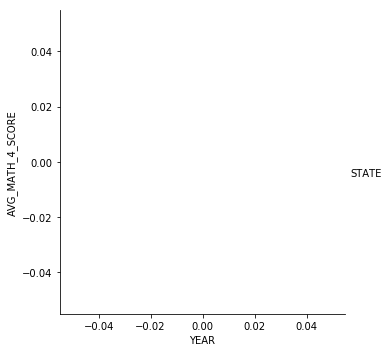

In [17]:
sns.lmplot(x="YEAR", y="AVG_MATH_4_SCORE", hue="STATE", data=df.dropna(), legend_out=True);

/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daviderickson/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


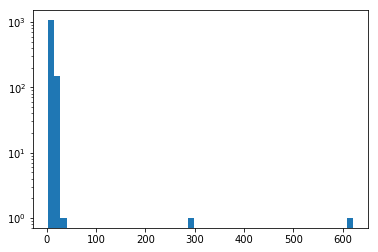

In [18]:
plt.hist('avg_total_expenditure', bins=50, log=True, data=df);

In [19]:
#For some reason VIRGINIA has 3 entries for 2008 and 2 of them have increicbly high avg_instruction_expenditure
df[df['avg_total_expenditure'] > 100]

,PRIMARY_KEY,STATE,YEAR,ENROLL,TOTAL_REVENUE,FEDERAL_REVENUE,STATE_REVENUE,LOCAL_REVENUE,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,...,fracn_rev_FEDERAL_REVENUE,fracn_rev_STATE_REVENUE,fracn_rev_LOCAL_REVENUE,fracn_enroll_GRADES_PK_G,fracn_enroll_GRADES_KG_G,fracn_enroll_GRADES_4_G,fracn_enroll_GRADES_8_G,fracn_enroll_GRADES_12_G,fracn_enroll_GRADES_1_8_G,fracn_enroll_GRADES_9_12_G
863,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,0.060781,0.403422,0.535796,0.033129,0.105619,0.090875,0.075236,0.049372,0.716857,0.250015
864,2008_VIRGINIA,VIRGINIA,2008,1230857.0,14768120.0,897627.0,5957786.0,7912707.0,15236306.0,8003167.0,...,0.060781,0.403422,0.535796,0.104667,0.140873,0.103771,0.060479,0.019712,0.783009,0.112324


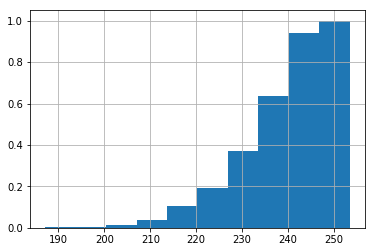

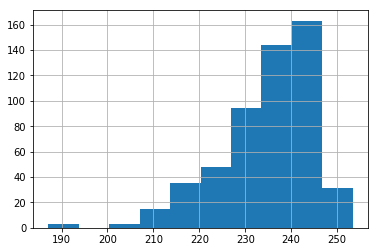

In [20]:
df['AVG_MATH_4_SCORE'].dropna().hist(density=True, cumulative=True)
plt.show()
df['AVG_MATH_4_SCORE'].dropna().hist()

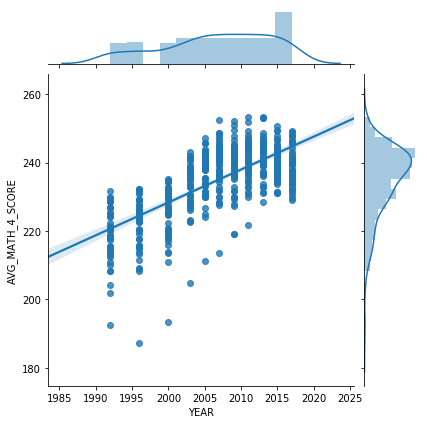

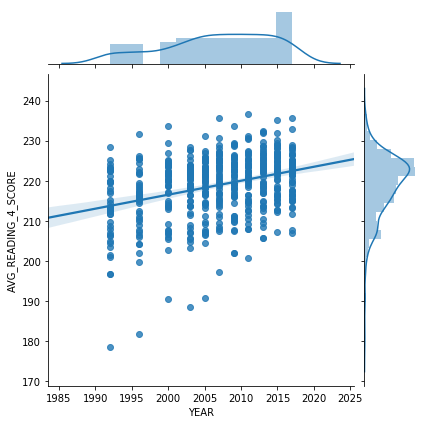

In [21]:
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_READING_4_SCORE", data=df, kind="reg")

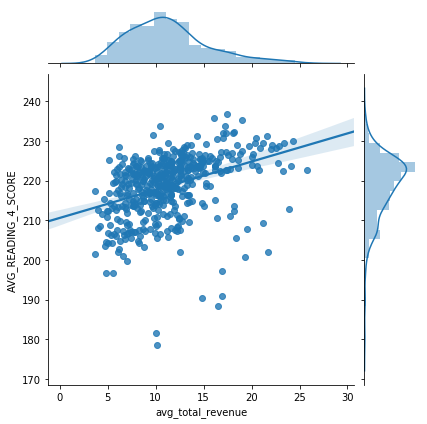

In [22]:
sns.jointplot("avg_total_revenue", "AVG_READING_4_SCORE", data=df, kind="reg")

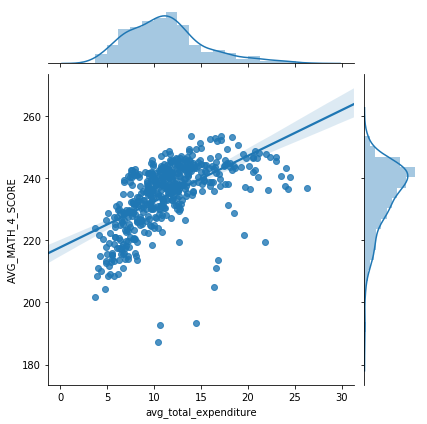

In [23]:
sns.jointplot("avg_total_expenditure", "AVG_MATH_4_SCORE", data=df, kind="reg")

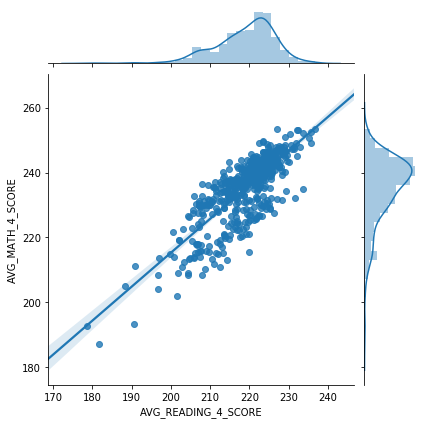

In [24]:
sns.jointplot("AVG_READING_4_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

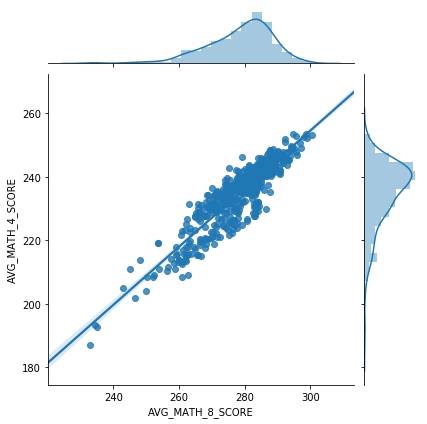

In [25]:
sns.jointplot("AVG_MATH_8_SCORE", "AVG_MATH_4_SCORE", data=df, kind="reg")

In [26]:
df1=df.drop(['PRIMARY_KEY','AVG_MATH_8_SCORE','AVG_READING_4_SCORE','AVG_READING_8_SCORE','ENROLL'],axis=1)
df1 = df1.dropna()
print(df1.columns)
df1 = pd.get_dummies(df1, columns=['STATE'])

y=df1.loc[:,'AVG_MATH_4_SCORE'].values
X=df1.drop(['AVG_MATH_4_SCORE'],axis=1).loc[:,:].values
X_cols=df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns

ts_cv = TimeSeriesSplit(n_splits=5)
print(ts_cv)
for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

"""
PredefinedSplit won't work because it folds in future data

test_fold = df1.loc[:,'YEAR'].values
ps = PredefinedSplit(test_fold)
print(ps.get_n_splits())
for train_index, test_index in ps.split():
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
"""

Index(['STATE', 'YEAR', 'TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE',
       'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE',
       'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE',
       'CAPITAL_OUTLAY_EXPENDITURE', 'GRADES_PK_G', 'GRADES_KG_G',
       'GRADES_4_G', 'GRADES_8_G', 'GRADES_12_G', 'GRADES_1_8_G',
       'GRADES_9_12_G', 'GRADES_ALL_G', 'AVG_MATH_4_SCORE',
       'avg_total_revenue', 'avg_total_expenditure', 'fracn_schoolage',
       'rev_per_person', 'exp_per_rev', 'recent_AVG_MATH_4_SCORE',
       'fracn_GRADES_12div8_G', 'fracn_exp_INSTRUCTION_EXPENDITURE',
       'fracn_exp_SUPPORT_SERVICES_EXPENDITURE', 'fracn_exp_OTHER_EXPENDITURE',
       'fracn_exp_CAPITAL_OUTLAY_EXPENDITURE', 'fracn_rev_FEDERAL_REVENUE',
       'fracn_rev_STATE_REVENUE', 'fracn_rev_LOCAL_REVENUE',
       'fracn_enroll_GRADES_PK_G', 'fracn_enroll_GRADES_KG_G',
       'fracn_enroll_GRADES_4_G', 'fracn_enroll_GRADES_8_G',
       'fracn_enroll_GRADES_12_G', 'fracn_enroll_

ValueError: Cannot have number of folds =6 greater than the number of samples: 0.

In [ ]:
n_splits=20
ts_cv = TimeSeriesSplit(n_splits=n_splits)
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=-1)

index=0
train_score = np.zeros(n_splits)
test_score = np.zeros(n_splits)

for train_index, test_index in ts_cv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]   
    
    rf_model.fit(X_train, y_train) 
    Y_rf=rf_model.predict(X_test)
    train_score[index]=rf_model.score(X_train,y_train) #Train score
    test_score[index]=rf_model.score(X_test,y_test) #Test score
    index+=1
index_list=np.arange(index)

In [ ]:
print(index)
print(index_list)
print(train_score)
print(test_score)

In [ ]:
plt.plot(index_list,train_score,'o', label="Train")
plt.plot(index_list,test_score,'o', label="Test")
plt.xlabel("Split")
plt.ylabel("R^2 Score")
plt.legend(loc="best")

In [ ]:
model=RandomForestRegressor()

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

"""
param_search = [
  {'n_estimators': [1, 10, 20, 100]}
]
gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
gsrch_rf_model.fit(X,y)
"""

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[4,5,6,7,8,9,10,20,30,40,50,60]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="n_estimators", param_range=param_range, cv=ts_cv, n_jobs=-1)

In [ ]:
train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.plot(param_range,train_scores_mean,'o',label="Train")
plt.plot(param_range,test_scores_mean,'o',label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
model=RandomForestRegressor(n_estimators=20)

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

In [ ]:
plt.figure()
plt.plot(train_sizes, -train_scores.mean(1), 'o-', color="g",
         label="Train")
plt.plot(train_sizes, -test_scores.mean(1), 'o-', color="r",
         label="Test")
plt.xlabel("Train Size")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)  

In [ ]:
Y_rf=rf_model.predict(X)
plt.plot(Y_rf, y, 'ro')
plt.show()

In [ ]:
rf_model.score(X,y)

In [ ]:
feature_importances_rf = pd.DataFrame(rf_model.feature_importances_, index = df1.drop(['AVG_MATH_4_SCORE'],axis=1).columns, columns=['importance']).sort_values('importance',ascending=False)
feature_importances_rf.head(10)

In [ ]:
sns.jointplot(x='YEAR', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_enroll_GRADES_12_G', y='AVG_MATH_4_SCORE', data=df, kind='reg')
sns.jointplot(x='fracn_rev_FEDERAL_REVENUE', y='AVG_MATH_4_SCORE', data=df, kind='reg')

In [ ]:
from sklearn import svm
svm_model = svm.SVR(gamma='scale')
svm_model.fit(X, y)  

In [ ]:
Y_svm=svm_model.predict(X)
plt.plot(Y_svm, y, 'ro')
plt.show()

# Lasso

In [ ]:
model=linear_model.Lasso(normalize=True)
param_search = [
  {'alpha': [0.00001,0.0001,0.001,0.01,0.1,1]}
 ]

num_splits=30
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

#gsrch_rf_model=GridSearchCV(estimator=model, param_grid=param_search, cv=ts_cv, n_jobs=-1)
#gsrch_rf_model.fit(X,y)

#train_sizes, train_scores, test_scores = \
#    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=10), cv=ts_cv, n_jobs=-1)

param_range=[0.00001,0.0001,0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.5,1]
train_scores_vc, test_scores_vc = \
    validation_curve(estimator=model, X=X, y=y, param_name="alpha", param_range=param_range, cv=ts_cv, n_jobs=-1)

train_scores_mean = np.mean(train_scores_vc, axis=1)
train_scores_std = np.std(train_scores_vc, axis=1)
test_scores_mean = np.mean(test_scores_vc, axis=1)
test_scores_std = np.std(test_scores_vc, axis=1)

plt.figure()
plt.semilogx(param_range,train_scores_mean,'o',label="Train")
plt.semilogx(param_range,test_scores_mean,'o',label="Test")
plt.semilogx(param_range,test_scores_mean,label="Test_curve")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.title("Validation Curves")
plt.legend(loc="best")

In [ ]:
"""Plot test data fit"""

In [ ]:
model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)

num_splits=5
ts_cv=TimeSeriesSplit(n_splits=num_splits) #.split(X)

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1,1.0,num=30), cv=ts_cv, n_jobs=-1)

print(train_sizes.shape,train_scores.shape, test_scores.shape)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes,train_scores_mean,'o',label="Train")
plt.plot(train_sizes,test_scores_mean,'o',label="Test")
plt.xlabel("Train Sizes")
plt.ylabel("Score")
plt.title("Learning Curves")
plt.legend(loc="best")

In [ ]:
model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X, y)  
Y_lasso=lasso_model.predict(X)
plt.plot(Y_lasso, y, 'ro')

# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_.round(), X_cols))

In [ ]:
scaler=StandardScaler()
X_transformed = scaler.fit_transform(X)


model=linear_model.Lasso(alpha=0.01, normalize=True)
lasso_model.fit(X_transformed, y)  
Y_lasso=lasso_model.predict(X_transformed)

lasso_coef_ = lasso_model.coef_
print(X_cols.shape)
#print(X_cols)
print(lasso_coef_.shape)
print(np.round(lasso_coef_))
#print(lasso_coef_)
X_cols[np.abs(lasso_coef_)>10]

sorted(zip(lasso_coef_, X_cols))

In [ ]:
"""fracn_GRADES_12div8_G
is not chosen by Lasso. RandomForest says it's #2 tho. Why?
Plot.
"""
plt.figure(figsize=[7,7])
x1=df1.loc[:,'fracn_GRADES_12div8_G'].values
plt.plot(x1,y,'o')
plt.plot(x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_GRADES_12div8_G")
plt.ylabel("y")

In [ ]:
plt.figure(figsize=[20,10])

plt.subplot(2, 2, 1)
x1=df1.loc[:,'fracn_enroll_GRADES_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 2)
x1=df1.loc[:,'fracn_enroll_GRADES_9_12_G'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("fracn_enroll_GRADES_9_12_G")
plt.ylabel("y")

plt.subplot(2, 2, 3)
x1=df1.loc[:,'YEAR'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("YEAR")
plt.ylabel("y")

plt.subplot(2, 2, 4)
x1=df1.loc[:,'STATE_DISTRICT_OF_COLUMBIA'].values
print(y.shape,np.shape(lasso_coef_*X),x1.shape)
plt.plot(x1,y,'o',x1,Y_lasso, alpha=0.7)
plt.legend(("y","fit_lasso"),loc=(0.7,0.2))
plt.xlabel("STATE_DISTRICT_OF_COLUMBIA")
plt.ylabel("y")

In [ ]:
plt.figure(figsize=[15,10])

plt.subplot(2, 2, 1)
plt.plot(Y_lasso,y,'o',Y_lasso,line,Y_lasso,Y_lasso)
plt.legend(("y","fit_lasso","y=x"),loc='best')
plt.xlabel("Y_lasso")
plt.ylabel("y")

In [ ]:
# Generated linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_lasso,y)
line = slope*Y_lasso+intercept

#need to make analysis_df that has y,Y_lasso

#Plot
#grid=sns.JointGrid(x=Y_lasso,y=y)
#g=grid.plot_joint(sns.scatterplot) #, hue='smoker'
#sns.scatterplot(Y_lasso,line, ax=g.ax_marg_x, legend=False)
#sns.lmplot(Y_lasso,Y_lasso,ax=g.ax_marg_x,legend=False)

#plt.subplot(1,2,1)
ax1 = sns.jointplot(x=Y_lasso,y=y,kind="kde")
#plt.subplot(1,2,2)
ax2 = sns.jointplot(x=Y_lasso,y=y,kind="resid")

In [ ]:
"""The largest coefficients are"""
X_cols[np.abs(lasso_coef_)>0.5]
""". Plot them with fits."""

plt.plot(Y_svm, y, 'ro')("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")
sns.jointplot("YEAR", "AVG_MATH_4_SCORE", data=df, kind="reg")


In [ ]:
"""
Can I predict test scores for a year?

Handle time better. Time_series_split

Time trends: 
-Scores
-Populations
-Revenues
-Expenditures

Delta from previous time point as feature?

Features:
-Elite? financials, location, 
-Good school? school history, tax rev, district
-Trends in time? Deltas in time. more money, more students, higher scores, ...


"""